Champions (one per league-season):
     season          league            team_name  points  goal_diff  \
60     2021      Bundesliga        Bayern Munich      77         60   
158    2022      Bundesliga        Bayern Munich      71         54   
20     2021         La Liga          Real Madrid      86         49   
118    2022         La Liga            Barcelona      88         50   
78     2021         Ligue 1  Paris Saint Germain      86         54   
176    2022         Ligue 1  Paris Saint Germain      85         49   
0      2021  Premier League      Manchester City      93         73   
98     2022  Premier League      Manchester City      89         61   
40     2021         Serie A             AC Milan      86         38   
138    2022         Serie A               Napoli      90         49   

     normalized_rank  
60               1.0  
158              1.0  
20               1.0  
118              1.0  
78               1.0  
176              1.0  
0                1.0  

C:\Users\kyle\AppData\Local\Temp\ipykernel_6960\476546162.py:215: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(seasons))


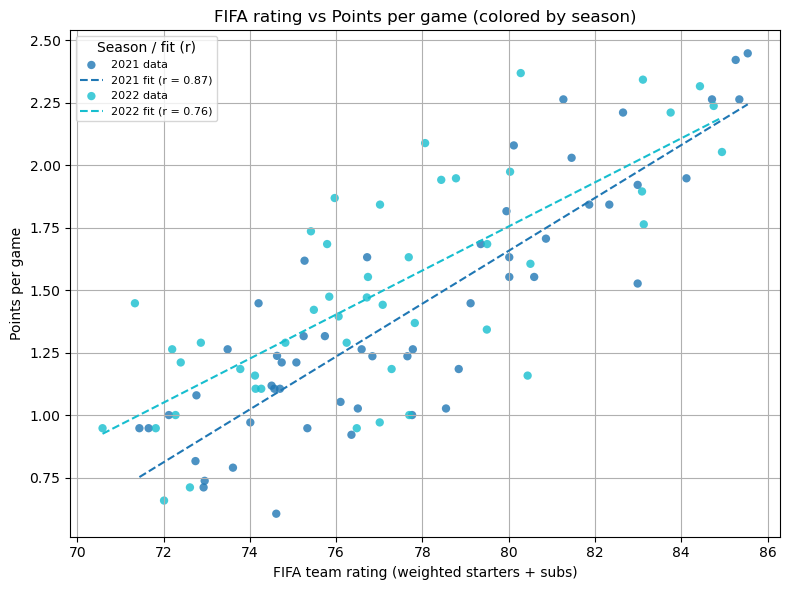

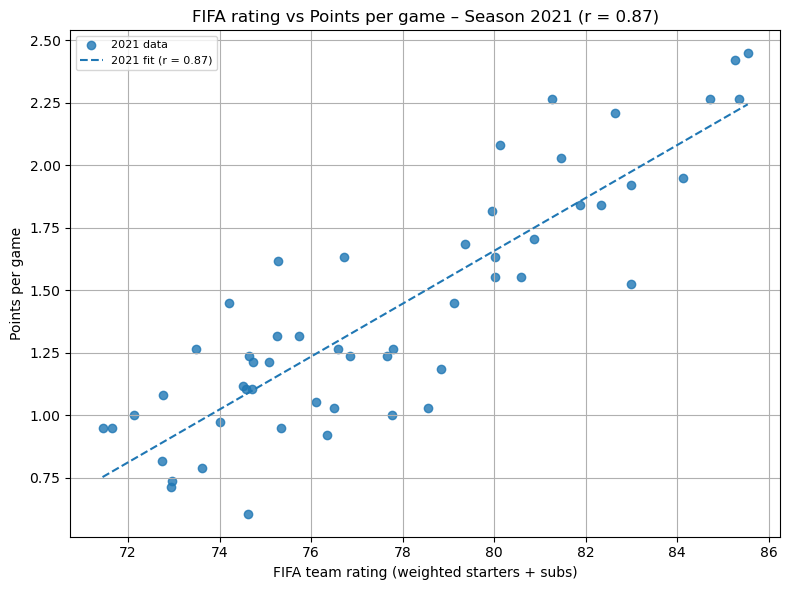

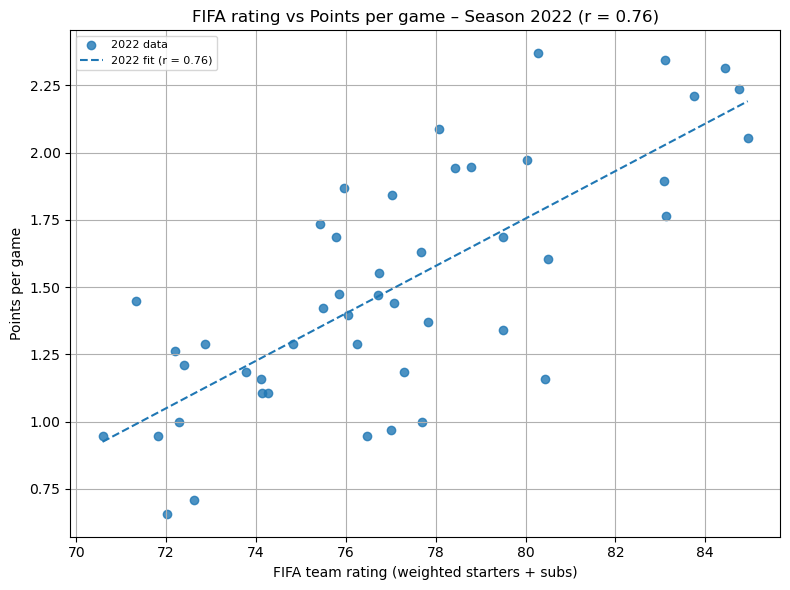

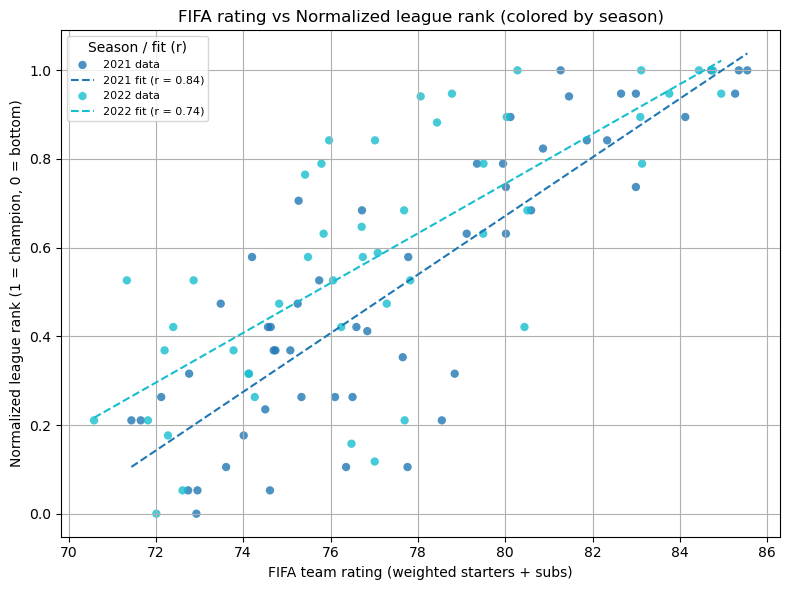

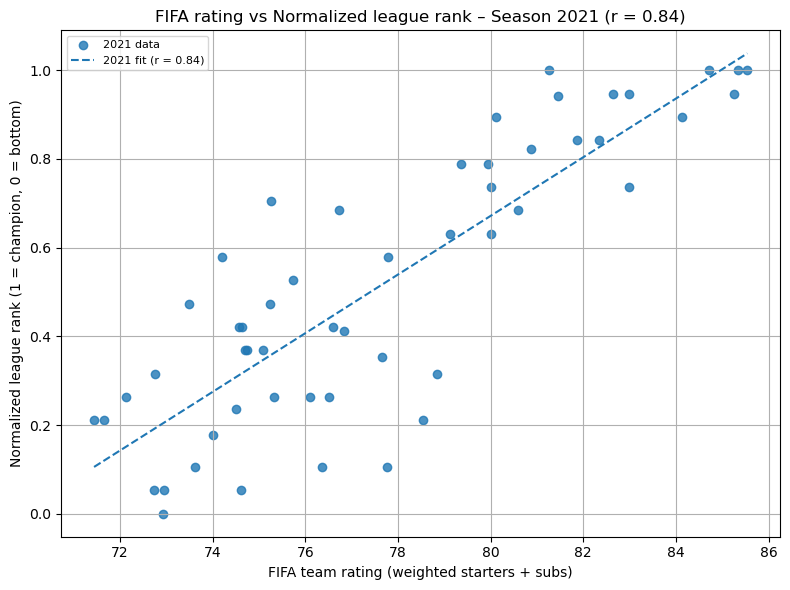

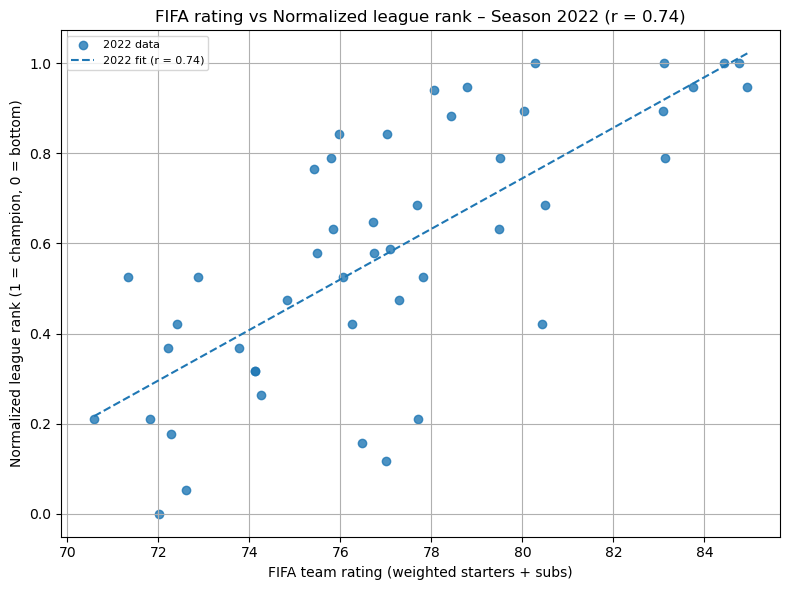

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ======================================================
# 1. LOAD DATA
# ======================================================

# Standings data (the CSV you shared)
standings = pd.read_csv("top5_leagues_standings.csv")

# Sofifa data (FIFA ratings)
sofifa = pd.read_csv("sofifa.csv")


# ======================================================
# 2. CLEAN SOFIFA: RATING, TEAM NAME, EDITION -> SEASON
# ======================================================

# Force Overall rating to numeric and drop bad entries
sofifa["Overall rating"] = pd.to_numeric(sofifa["Overall rating"], errors="coerce")
sofifa = sofifa.dropna(subset=["Overall rating"])


def extract_team(team_contract):
    """Get team name from 'Team & Contract' (before newline)."""
    if isinstance(team_contract, str):
        return team_contract.split("\n")[0].strip()
    return None

sofifa["team_name"] = sofifa["Team & Contract"].apply(extract_team)


def extract_fifa_number(edition):
    """'FIFA 15' -> 15 as int."""
    if isinstance(edition, str):
        parts = edition.split()
        try:
            return int(parts[-1])
        except ValueError:
            return None
    return None

sofifa["fifa_number"] = sofifa["Edition"].apply(extract_fifa_number)


def fifa_to_season_year(fifa_number):
    """
    Map FIFA edition to approximate season year.
    Example: FIFA 22 -> 2021, FIFA 23 -> 2022, etc.
    Adjust if your project defines this differently.
    """
    if pd.isna(fifa_number):
        return None
    return 2000 + fifa_number - 1

sofifa["season"] = sofifa["fifa_number"].apply(fifa_to_season_year)


# ======================================================
# 3. NORMALIZE TEAM NAMES IN BOTH DATASETS
# ======================================================

def normalize_team_name(name):
    """
    Make team names more consistent between API and sofifa.
    Lowercase, strip punctuation, remove 'fc', 'cf', etc.
    """
    if not isinstance(name, str):
        return None

    s = name.lower()

    # unify separators
    s = s.replace("-", " ")
    s = s.replace(".", " ")

    # remove common tokens
    remove_tokens = [
        "fc", "cf", "club", "football club",
        "cf.", "fc.", "c.f.", "f.c.",
    ]
    for tok in remove_tokens:
        s = re.sub(rf"\b{tok}\b", " ", s)

    # special-case fixes if you see mismatches, you can add more
    s = s.replace("manchester utd", "manchester united")
    # e.g., if one source had "psg" and another "paris saint germain", you could normalize that too

    # collapse spaces
    s = re.sub(r"\s+", " ", s).strip()

    return s

# From standings
standings["team_name_clean"] = standings["team_name"].apply(normalize_team_name)

# From sofifa
sofifa["team_name_clean"] = sofifa["team_name"].apply(normalize_team_name)


# ======================================================
# 4. BUILD REAL-WORLD PERFORMANCE METRICS + RANKING
# ======================================================

df_perf = standings.copy()

# Basic performance metrics
df_perf["points_per_game"] = df_perf["points"] / df_perf["played"]
df_perf["win_rate"] = df_perf["wins"] / df_perf["played"]
df_perf["draw_rate"] = df_perf["draws"] / df_perf["played"]
df_perf["loss_rate"] = df_perf["losses"] / df_perf["played"]

# Sort so that best teams come first within each (league, season)
df_perf = df_perf.sort_values(
    ["league", "season", "points", "goal_diff"],
    ascending=[True, True, False, False]
)

# Rank within (league, season)
df_perf["rank"] = df_perf.groupby(["league", "season"]).cumcount() + 1

# Number of teams in each league/season
df_perf["teams_in_league"] = df_perf.groupby(["league", "season"])["team_name"].transform("count")

# Normalized rank: 1.0 = champion, 0.0 = bottom team
df_perf["normalized_rank"] = 1 - (df_perf["rank"] - 1) / (df_perf["teams_in_league"] - 1)

# (Sanity check) there should be 10 champions total
champions = df_perf[df_perf["rank"] == 1][["season", "league", "team_name", "points", "goal_diff", "normalized_rank"]]
print("Champions (one per league-season):")
print(champions)
print("\nNumber of champions:", champions.shape[0])


# ======================================================
# 5. COMPUTE TEAM-LEVEL FIFA RATINGS (STARTERS VS SUBS)
# ======================================================

def compute_team_ratings(group, n_starters=11, n_subs=7,
                         starter_weight=0.7, sub_weight=0.3):
    """
    Given a group of players for one (team_name_clean, season),
    compute starter mean, sub mean, and weighted team rating.
    """
    g = group.dropna(subset=["Overall rating"]).copy()
    if g.empty:
        return pd.Series({
            "starter_mean": np.nan,
            "sub_mean": np.nan,
            "team_rating_weighted": np.nan,
            "num_players": 0
        })

    g = g.sort_values("Overall rating", ascending=False)

    starters = g.head(n_starters)
    subs = g.iloc[n_starters:n_starters + n_subs]

    starter_mean = starters["Overall rating"].mean()
    sub_mean = subs["Overall rating"].mean() if len(subs) > 0 else np.nan

    if np.isnan(sub_mean):
        team_rating_weighted = starter_mean
    else:
        team_rating_weighted = starter_weight * starter_mean + sub_weight * sub_mean

    return pd.Series({
        "starter_mean": starter_mean,
        "sub_mean": sub_mean,
        "team_rating_weighted": team_rating_weighted,
        "num_players": len(g)
    })

team_fifa = (
    sofifa
    .groupby(["team_name_clean", "season"])
    .apply(compute_team_ratings)
    .reset_index()
)

print("\nSample FIFA team ratings:")
print(team_fifa.head())


# ======================================================
# 6. MERGE PERFORMANCE + FIFA RATINGS
# ======================================================

merged = pd.merge(
    df_perf,
    team_fifa,
    on=["team_name_clean", "season"],
    how="left",  # keep all standings rows even if no FIFA rating
    suffixes=("", "_fifa")
)

# For plotting, keep only rows where we actually have a FIFA rating
merged_plot = merged.dropna(subset=["team_rating_weighted"]).copy()

print("\nMerged data sample:")
print(merged_plot[[
    "season", "league", "team_name",
    "points_per_game", "normalized_rank",
    "starter_mean", "sub_mean", "team_rating_weighted"
]].head())


# ======================================================
# 7. PLOTS WITH SEASON AS HUE + SEPARATE PER SEASON
# ======================================================

seasons = sorted(merged_plot["season"].dropna().unique())
cmap = plt.cm.get_cmap("tab10", len(seasons))

def add_regression_line(ax, x, y, label_prefix=None, color=None):
    """Add line of best fit and return correlation coefficient."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        return None  # not enough points

    x_valid = x[mask]
    y_valid = y[mask]

    # Fit line y = m x + b
    m, b = np.polyfit(x_valid, y_valid, 1)
    x_line = np.linspace(x_valid.min(), x_valid.max(), 100)
    y_line = m * x_line + b

    # Pearson correlation
    r = np.corrcoef(x_valid, y_valid)[0, 1]

    if label_prefix is None:
        label = f"Best fit (r = {r:.2f})"
    else:
        label = f"{label_prefix} fit (r = {r:.2f})"

    ax.plot(x_line, y_line, linestyle="--", color=color, label=label)
    return r


# ---------- Plot 1: Rating vs Points per Game (all seasons, colored by season) ----------
fig, ax = plt.subplots(figsize=(8, 6))

for i, season in enumerate(seasons):
    sub = merged_plot[merged_plot["season"] == season]
    color = cmap(i)
    ax.scatter(
        sub["team_rating_weighted"],
        sub["points_per_game"],
        label=f"{season} data",
        color=color,
        alpha=0.8,
        edgecolor="none",
    )
    # Add regression line + r for this season
    add_regression_line(
        ax,
        sub["team_rating_weighted"],
        sub["points_per_game"],
        label_prefix=str(season),
        color=color,
    )

ax.set_xlabel("FIFA team rating (weighted starters + subs)")
ax.set_ylabel("Points per game")
ax.set_title("FIFA rating vs Points per game (colored by season)")
ax.grid(True)
ax.legend(title="Season / fit (r)", fontsize=8)
fig.tight_layout()
plt.show()


# ---------- Plot 1b: Rating vs Points per Game (separate figure per season) ----------
for season in seasons:
    sub = merged_plot[merged_plot["season"] == season]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(
        sub["team_rating_weighted"],
        sub["points_per_game"],
        alpha=0.8,
        label=f"{season} data",
    )
    r = add_regression_line(
        ax,
        sub["team_rating_weighted"],
        sub["points_per_game"],
        label_prefix=str(season),
    )
    ax.set_xlabel("FIFA team rating (weighted starters + subs)")
    ax.set_ylabel("Points per game")
    title = f"FIFA rating vs Points per game – Season {season}"
    if r is not None:
        title += f" (r = {r:.2f})"
    ax.set_title(title)
    ax.grid(True)
    ax.legend(fontsize=8)
    fig.tight_layout()
    plt.show()


# ---------- Plot 2: Rating vs Normalized League Rank (all seasons, colored by season) ----------
fig, ax = plt.subplots(figsize=(8, 6))

for i, season in enumerate(seasons):
    sub = merged_plot[merged_plot["season"] == season]
    color = cmap(i)
    ax.scatter(
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        label=f"{season} data",
        color=color,
        alpha=0.8,
        edgecolor="none",
    )
    add_regression_line(
        ax,
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        label_prefix=str(season),
        color=color,
    )

ax.set_xlabel("FIFA team rating (weighted starters + subs)")
ax.set_ylabel("Normalized league rank (1 = champion, 0 = bottom)")
ax.set_title("FIFA rating vs Normalized league rank (colored by season)")
ax.grid(True)
ax.legend(title="Season / fit (r)", fontsize=8)
fig.tight_layout()
plt.show()


# ---------- Plot 2b: Rating vs Normalized Rank (separate figure per season) ----------
for season in seasons:
    sub = merged_plot[merged_plot["season"] == season]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        alpha=0.8,
        label=f"{season} data",
    )
    r = add_regression_line(
        ax,
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        label_prefix=str(season),
    )
    ax.set_xlabel("FIFA team rating (weighted starters + subs)")
    ax.set_ylabel("Normalized league rank (1 = champion, 0 = bottom)")
    title = f"FIFA rating vs Normalized league rank – Season {season}"
    if r is not None:
        title += f" (r = {r:.2f})"
    ax.set_title(title)
    ax.grid(True)
    ax.legend(fontsize=8)
    fig.tight_layout()
    plt.show()

C:\Users\kyle\AppData\Local\Temp\ipykernel_6960\2414487274.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(seasons))


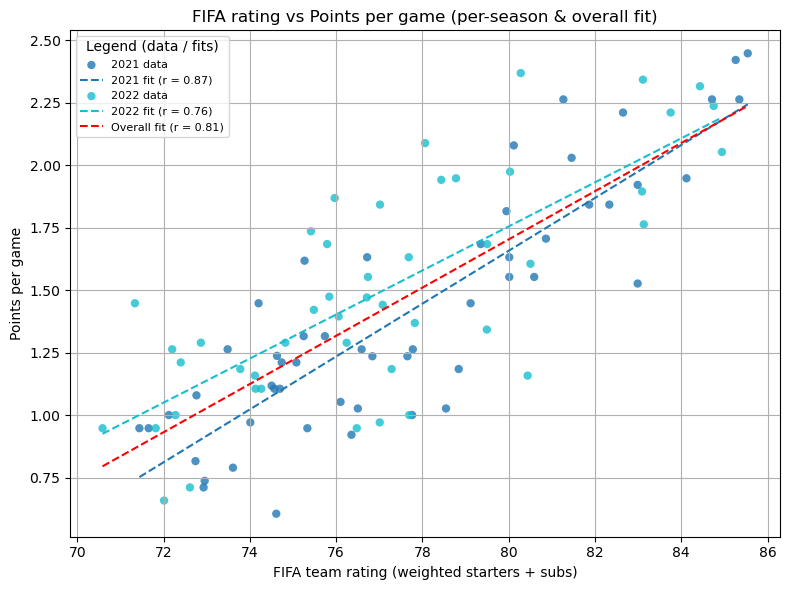

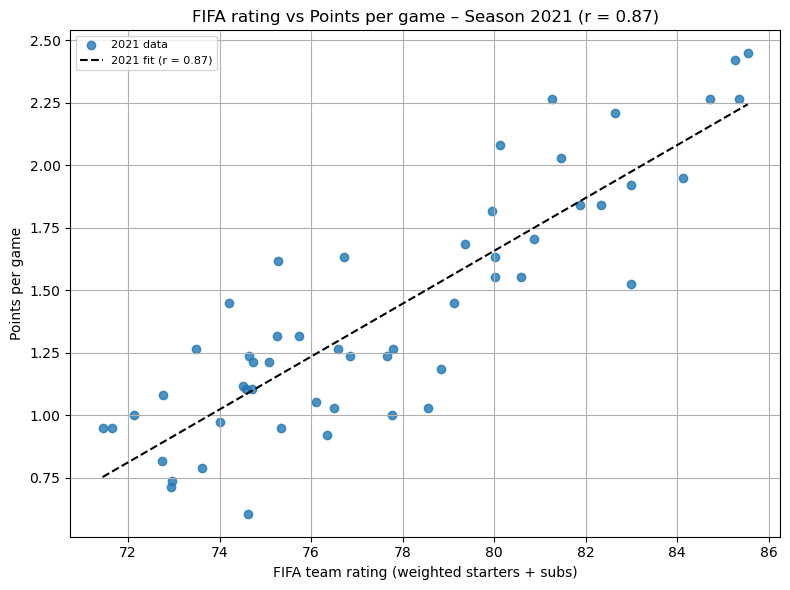

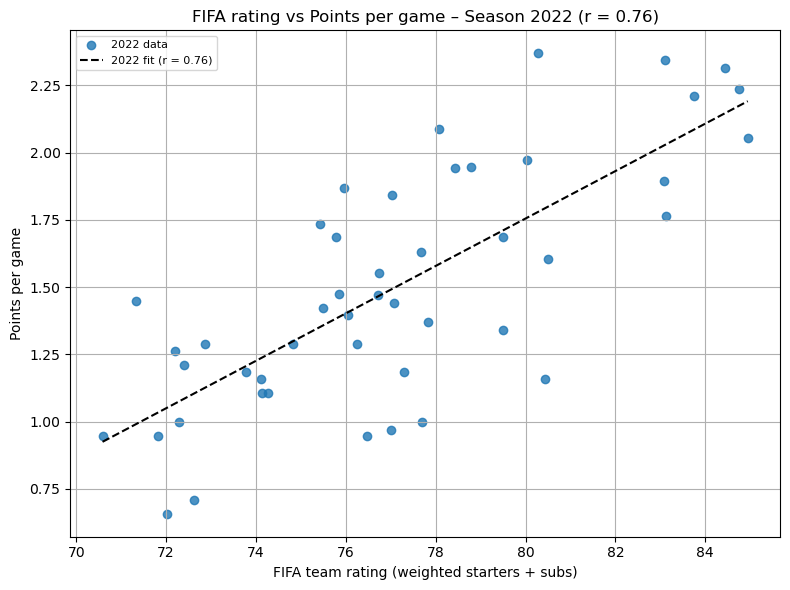

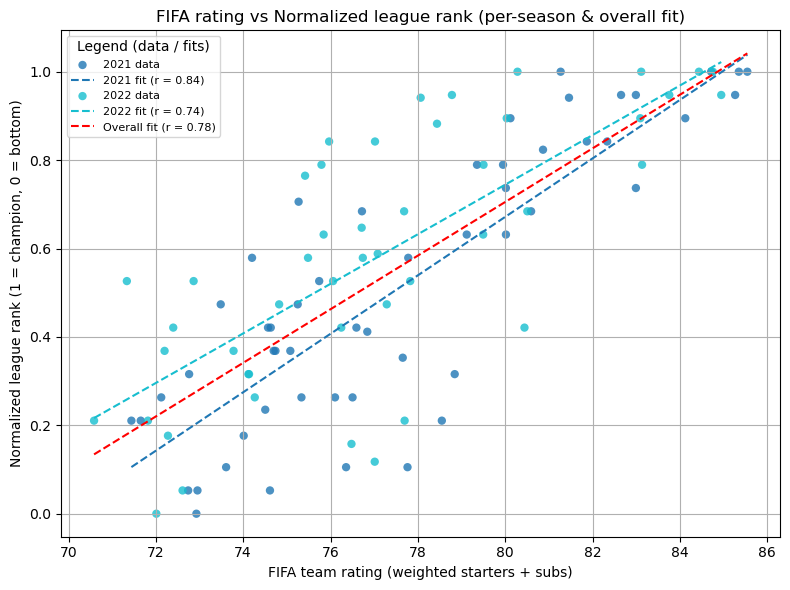

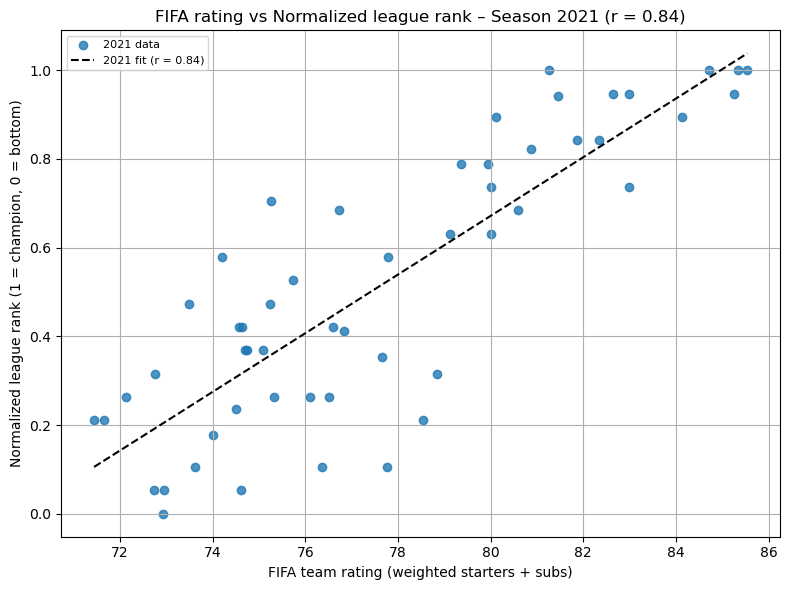

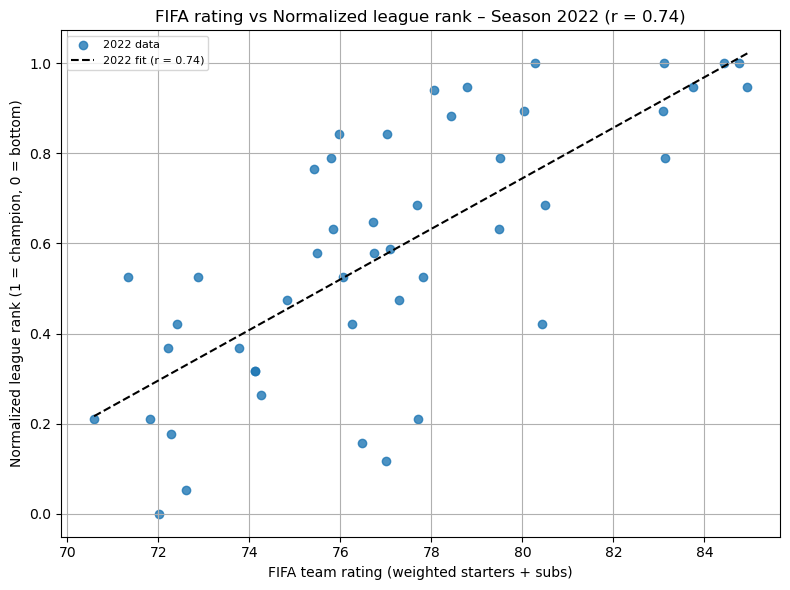

In [10]:
seasons = sorted(merged_plot["season"].dropna().unique())
cmap = plt.cm.get_cmap("tab10", len(seasons))

def add_regression_line(ax, x, y, label, color, linestyle="--"):
    """
    Add line of best fit (y = m x + b) to 'ax' and return Pearson r.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        return None

    x_valid = x[mask]
    y_valid = y[mask]

    # Fit line y = m x + b
    m, b = np.polyfit(x_valid, y_valid, 1)
    x_line = np.linspace(x_valid.min(), x_valid.max(), 100)
    y_line = m * x_line + b

    # Pearson correlation
    r = np.corrcoef(x_valid, y_valid)[0, 1]

    ax.plot(x_line, y_line, linestyle=linestyle, color=color,
            label=f"{label} (r = {r:.2f})")
    return r


# ---------- Plot 1: Rating vs Points per Game (all seasons, colored by season) ----------
fig, ax = plt.subplots(figsize=(8, 6))

# per-season scatter + per-season fits
for i, season in enumerate(seasons):
    sub = merged_plot[merged_plot["season"] == season]
    color = cmap(i)
    ax.scatter(
        sub["team_rating_weighted"],
        sub["points_per_game"],
        label=f"{season} data",
        color=color,
        alpha=0.8,
        edgecolor="none",
    )
    add_regression_line(
        ax,
        sub["team_rating_weighted"],
        sub["points_per_game"],
        label=f"{season} fit",
        color=color,
        linestyle="--",
    )

# overall fit across all seasons (red dashed)
add_regression_line(
    ax,
    merged_plot["team_rating_weighted"],
    merged_plot["points_per_game"],
    label="Overall fit",
    color="red",
    linestyle="--",
)

ax.set_xlabel("FIFA team rating (weighted starters + subs)")
ax.set_ylabel("Points per game")
ax.set_title("FIFA rating vs Points per game (per-season & overall fit)")
ax.grid(True)
ax.legend(title="Legend (data / fits)", fontsize=8)
fig.tight_layout()
plt.show()


# ---------- Plot 1b: Rating vs Points per Game (separate figure per season) ----------
for season in seasons:
    sub = merged_plot[merged_plot["season"] == season]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(
        sub["team_rating_weighted"],
        sub["points_per_game"],
        alpha=0.8,
        label=f"{season} data",
    )
    r = add_regression_line(
        ax,
        sub["team_rating_weighted"],
        sub["points_per_game"],
        label=f"{season} fit",
        color="black",
        linestyle="--",
    )
    ax.set_xlabel("FIFA team rating (weighted starters + subs)")
    ax.set_ylabel("Points per game")
    title = f"FIFA rating vs Points per game – Season {season}"
    if r is not None:
        title += f" (r = {r:.2f})"
    ax.set_title(title)
    ax.grid(True)
    ax.legend(fontsize=8)
    fig.tight_layout()
    plt.show()


# ---------- Plot 2: Rating vs Normalized League Rank (all seasons, colored by season) ----------
fig, ax = plt.subplots(figsize=(8, 6))

# per-season scatter + per-season fits
for i, season in enumerate(seasons):
    sub = merged_plot[merged_plot["season"] == season]
    color = cmap(i)
    ax.scatter(
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        label=f"{season} data",
        color=color,
        alpha=0.8,
        edgecolor="none",
    )
    add_regression_line(
        ax,
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        label=f"{season} fit",
        color=color,
        linestyle="--",
    )

# overall fit across all seasons (red dashed)
add_regression_line(
    ax,
    merged_plot["team_rating_weighted"],
    merged_plot["normalized_rank"],
    label="Overall fit",
    color="red",
    linestyle="--",
)

ax.set_xlabel("FIFA team rating (weighted starters + subs)")
ax.set_ylabel("Normalized league rank (1 = champion, 0 = bottom)")
ax.set_title("FIFA rating vs Normalized league rank (per-season & overall fit)")
ax.grid(True)
ax.legend(title="Legend (data / fits)", fontsize=8)
fig.tight_layout()
plt.show()


# ---------- Plot 2b: Rating vs Normalized Rank (separate figure per season) ----------
for season in seasons:
    sub = merged_plot[merged_plot["season"] == season]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        alpha=0.8,
        label=f"{season} data",
    )
    r = add_regression_line(
        ax,
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        label=f"{season} fit",
        color="black",
        linestyle="--",
    )
    ax.set_xlabel("FIFA team rating (weighted starters + subs)")
    ax.set_ylabel("Normalized league rank (1 = champion, 0 = bottom)")
    title = f"FIFA rating vs Normalized league rank – Season {season}"
    if r is not None:
        title += f" (r = {r:.2f})"
    ax.set_title(title)
    ax.grid(True)
    ax.legend(fontsize=8)
    fig.tight_layout()
    plt.show()

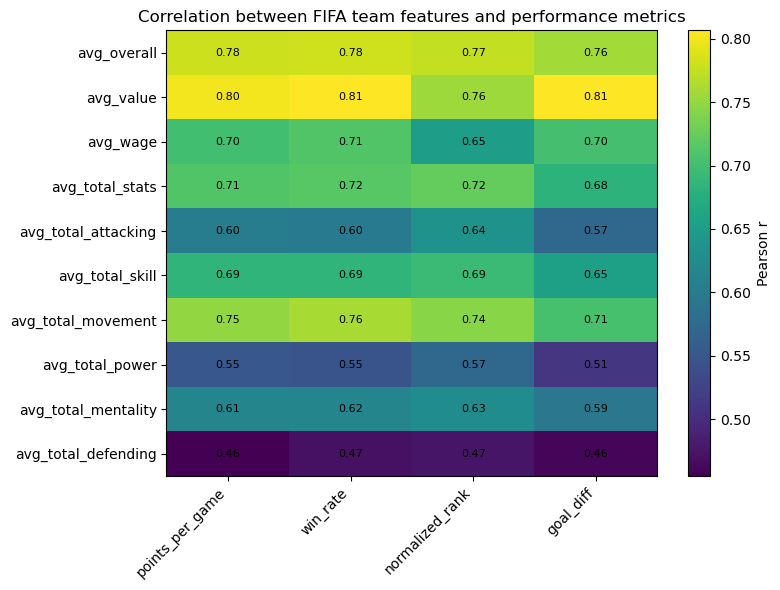

In [11]:
def extract_team(team_contract):
    if isinstance(team_contract, str):
        return team_contract.split("\n")[0].strip()
    return None

sofifa["team_name"] = sofifa["Team & Contract"].apply(extract_team)

# Extract FIFA edition number "FIFA 15" -> 15
def extract_fifa_number(edition):
    if isinstance(edition, str):
        parts = edition.split()
        try:
            return int(parts[-1])
        except ValueError:
            return None
    return None

sofifa["fifa_number"] = sofifa["Edition"].apply(extract_fifa_number)

# Map FIFA edition to (approximate) season year
def fifa_to_season_year(fifa_number):
    if pd.isna(fifa_number):
        return None
    return 2000 + fifa_number - 1   # e.g. FIFA 22 → 2021

sofifa["season"] = sofifa["fifa_number"].apply(fifa_to_season_year)

# --- Parse money columns (Value, Wage) like "€100.5M" ---

def parse_euro(s):
    if not isinstance(s, str):
        return np.nan
    s = s.replace("€", "").strip()
    if s.endswith("M"):
        return float(s[:-1]) * 1e6
    if s.endswith("K"):
        return float(s[:-1]) * 1e3
    try:
        return float(s)
    except ValueError:
        return np.nan

sofifa["Value_num"] = sofifa["Value"].apply(parse_euro)
sofifa["Wage_num"] = sofifa["Wage"].apply(parse_euro)

# Make total-stat columns numeric (if they exist)
for col in [
    "Total attacking", "Total skill", "Total movement", "Total power",
    "Total mentality", "Total defending", "Total stats"
]:
    if col in sofifa.columns:
        sofifa[col] = pd.to_numeric(sofifa[col], errors="coerce")

# --- Normalize team names in BOTH dfs for better matching ---

def normalize_team_name(name):
    if not isinstance(name, str):
        return None
    s = name.lower()
    s = s.replace("-", " ").replace(".", " ")
    for tok in ["fc", "cf", "club", "football club", "cf.", "fc.", "c.f.", "f.c."]:
        s = re.sub(rf"\b{tok}\b", " ", s)
    s = s.replace("manchester utd", "manchester united")
    s = re.sub(r"\s+", " ", s).strip()
    return s

standings["team_name_clean"] = standings["team_name"].apply(normalize_team_name)
sofifa["team_name_clean"] = sofifa["team_name"].apply(normalize_team_name)

# =========================
# REAL-WORLD PERFORMANCE FEATURES
# =========================

df_perf = standings.copy()
df_perf["points_per_game"] = df_perf["points"] / df_perf["played"]
df_perf["win_rate"] = df_perf["wins"] / df_perf["played"]
df_perf["draw_rate"] = df_perf["draws"] / df_perf["played"]
df_perf["loss_rate"] = df_perf["losses"] / df_perf["played"]

# rank & normalized_rank (1 = champion, 0 = bottom)
df_perf = df_perf.sort_values(
    ["league", "season", "points", "goal_diff"],
    ascending=[True, True, False, False]
)
df_perf["rank"] = df_perf.groupby(["league", "season"]).cumcount() + 1
df_perf["teams_in_league"] = df_perf.groupby(
    ["league", "season"]
)["team_name"].transform("count")
df_perf["normalized_rank"] = 1 - (df_perf["rank"] - 1) / (df_perf["teams_in_league"] - 1)

# =========================
# TEAM-LEVEL FIFA FEATURES
# =========================

# choose FIFA columns to aggregate
fifa_feature_cols = [
    "Overall rating", "Value_num", "Wage_num",
    "Total stats", "Total attacking", "Total skill",
    "Total movement", "Total power", "Total mentality", "Total defending"
]
# keep only the ones that actually exist
fifa_feature_cols = [c for c in fifa_feature_cols if c in sofifa.columns]

team_fifa_feats = (
    sofifa
    .groupby(["team_name_clean", "season"])[fifa_feature_cols]
    .mean()
    .reset_index()
)

# rename columns to clearer names
rename_map = {
    "Overall rating": "avg_overall",
    "Value_num": "avg_value",
    "Wage_num": "avg_wage",
    "Total stats": "avg_total_stats",
    "Total attacking": "avg_total_attacking",
    "Total skill": "avg_total_skill",
    "Total movement": "avg_total_movement",
    "Total power": "avg_total_power",
    "Total mentality": "avg_total_mentality",
    "Total defending": "avg_total_defending",
}
team_fifa_feats = team_fifa_feats.rename(columns=rename_map)

# =========================
# MERGE: FIFA FEATURES + PERFORMANCE
# =========================

merged_features = pd.merge(
    df_perf,
    team_fifa_feats,
    on=["team_name_clean", "season"],
    how="inner"   # only teams with both standings & FIFA data
)

# pick FIFA features and performance metrics to compare
fifa_features = [
    "avg_overall", "avg_value", "avg_wage",
    "avg_total_stats", "avg_total_attacking",
    "avg_total_skill", "avg_total_movement",
    "avg_total_power", "avg_total_mentality",
    "avg_total_defending",
]
fifa_features = [c for c in fifa_features if c in merged_features.columns]

perf_metrics = [
    "points_per_game", "win_rate",
    "normalized_rank", "goal_diff",
]

corr = merged_features[fifa_features + perf_metrics].corr()
subcorr = corr.loc[fifa_features, perf_metrics]

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(subcorr, aspect="auto")

ax.set_xticks(np.arange(len(perf_metrics)))
ax.set_yticks(np.arange(len(fifa_features)))
ax.set_xticklabels(perf_metrics, rotation=45, ha="right")
ax.set_yticklabels(fifa_features)

# annotate each cell with r value
for i in range(len(fifa_features)):
    for j in range(len(perf_metrics)):
        ax.text(
            j, i,
            f"{subcorr.iloc[i, j]:.2f}",
            ha="center", va="center", fontsize=8
        )

ax.set_title("Correlation between FIFA team features and performance metrics")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Pearson r")
plt.tight_layout()
plt.show()

   season  r_points_per_game  r_normalized_rank
0    2021           0.739743           0.697770
1    2022           0.716289           0.729958
2    2023           0.729565           0.658129
3    2024           0.772238           0.708440
4    2025           0.690115           0.664211


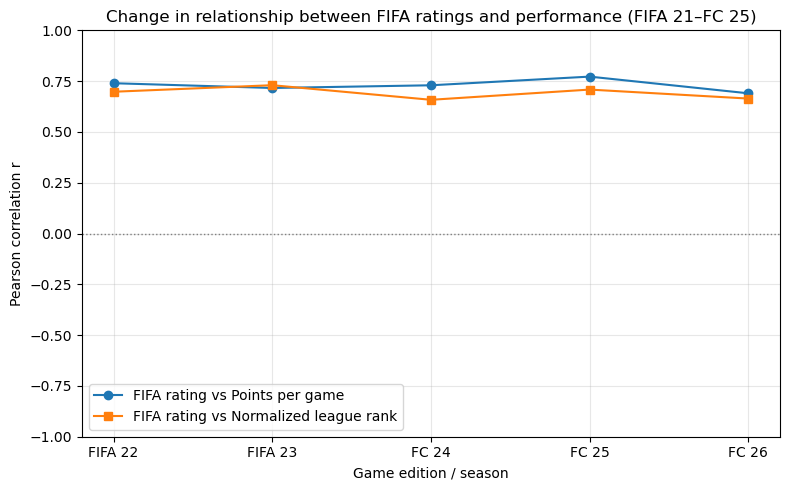

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ======================================================
# 1. LOAD DATA
# ======================================================

# New standings dataset (2021–2025)
standings = pd.read_csv("futball_21_25.csv")

# Sofifa player dataset (same one you used before)
sofifa = pd.read_csv("sofifa.csv")


# ======================================================
# 2. BUILD REAL-WORLD PERFORMANCE FEATURES
# ======================================================

# basic performance metrics
standings["points_per_game"] = standings["points"] / standings["played"]
standings["win_rate"] = standings["wins"] / standings["played"]
standings["draw_rate"] = standings["draws"] / standings["played"]
standings["loss_rate"] = standings["losses"] / standings["played"]

# sort and rank within (league, season) by points, then goal diff
standings = standings.sort_values(
    ["league", "season", "points", "goal_diff"],
    ascending=[True, True, False, False]
)
standings["rank"] = standings.groupby(["league", "season"]).cumcount() + 1
standings["teams_in_league"] = standings.groupby(
    ["league", "season"]
)["team_name"].transform("count")

# normalized rank: 1 = champion, 0 = bottom
standings["normalized_rank"] = 1 - (standings["rank"] - 1) / (
    standings["teams_in_league"] - 1
)


# ======================================================
# 3. PREP SOFIFA: SEASON + CLEAN TEAM NAMES + RATINGS
# ======================================================

# force ratings numeric
sofifa["Overall rating"] = pd.to_numeric(sofifa["Overall rating"], errors="coerce")

# extract team name from "Team & Contract"
def extract_team(team_contract):
    if isinstance(team_contract, str):
        return team_contract.split("\n")[0].strip()
    return None

sofifa["team_name"] = sofifa["Team & Contract"].apply(extract_team)

# FIFA edition -> number (e.g. "FIFA 22" -> 22)
def extract_fifa_number(edition):
    if isinstance(edition, str):
        parts = edition.split()
        try:
            return int(parts[-1])
        except ValueError:
            return None
    return None

sofifa["fifa_number"] = sofifa["Edition"].apply(extract_fifa_number)

# Map FIFA edition to (approximate) season year
# Adjust if your mapping is different.
def fifa_to_season_year(fifa_number):
    if pd.isna(fifa_number):
        return None
    return 2000 + fifa_number   # e.g. FIFA 22 -> season 2021

sofifa["season"] = sofifa["fifa_number"].apply(fifa_to_season_year)


# normalize team names in BOTH dfs for better matching
def normalize_team_name(name):
    if not isinstance(name, str):
        return None
    s = name.lower()
    s = s.replace("-", " ").replace(".", " ")
    for tok in ["fc", "cf", "club", "football club", "cf.", "fc.", "c.f.", "f.c."]:
        s = re.sub(rf"\b{tok}\b", " ", s)
    s = s.replace("manchester utd", "manchester united")
    s = re.sub(r"\s+", " ", s).strip()
    return s

standings["team_name_clean"] = standings["team_name"].apply(normalize_team_name)
sofifa["team_name_clean"] = sofifa["team_name"].apply(normalize_team_name)


# ======================================================
# 4. COMPUTE TEAM-LEVEL FIFA RATING (STARTERS + SUBS)
# ======================================================

def compute_team_rating(group, n_players=16):
    g = group.dropna(subset=["Overall rating"]).copy()
    if g.empty:
        return pd.Series({
            "team_rating_equal16": np.nan,
            "num_players_used": 0
        })

    # Sort by rating, best first
    g = g.sort_values("Overall rating", ascending=False)

    # Take top 16 (or fewer if team has less than 16 players in the data)
    top = g.head(n_players)

    # Simple average of those players
    team_mean = top["Overall rating"].mean()

    return pd.Series({
        "team_rating_weighted": team_mean,
        "num_players_used": len(top)
    })

team_fifa = (
    sofifa
    .groupby(["team_name_clean", "season"])
    .apply(compute_team_rating)
    .reset_index()
)

team_fifa = (
    sofifa
    .groupby(["team_name_clean", "season"])
    .apply(compute_team_rating)
    .reset_index()
)


# ======================================================
# 5. MERGE STANDINGS + FIFA RATINGS
# ======================================================

merged = pd.merge(
    standings,
    team_fifa[["team_name_clean", "season", "team_rating_weighted"]],
    on=["team_name_clean", "season"],
    how="inner"
)

# this is the dataset we’ll analyze
merged_plot = merged.dropna(subset=["team_rating_weighted"]).copy()


# ======================================================
# 6. CORRELATION OVER TIME: FIFA RATING VS PERFORMANCE
# ======================================================

def season_corr(df, x_col, y_col):
    x = df[x_col].to_numpy(dtype=float)
    y = df[y_col].to_numpy(dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        return np.nan
    return np.corrcoef(x[mask], y[mask])[0, 1]

rows = []
for season in sorted(merged_plot["season"].dropna().unique()):
    sub = merged_plot[merged_plot["season"] == season]
    r_points = season_corr(sub, "team_rating_weighted", "points_per_game")
    r_rank   = season_corr(sub, "team_rating_weighted", "normalized_rank")
    rows.append({
        "season": season,
        "r_points_per_game": r_points,
        "r_normalized_rank": r_rank,
    })

corr_by_season = pd.DataFrame(rows)
print(corr_by_season)

# map season -> FIFA edition label (adjust if needed)
edition_map = {
    2020: "FIFA 21",
    2021: "FIFA 22",
    2022: "FIFA 23",
    2023: "FC 24",
    2024: "FC 25",
    2025: "FC 26",
}
corr_by_season["edition"] = corr_by_season["season"].map(
    edition_map
).fillna(corr_by_season["season"].astype(str))


# ======================================================
# 7. PLOT: HOW REALISTIC ARE RATINGS OVER TIME?
# ======================================================

plt.figure(figsize=(8, 5))

plt.plot(
    corr_by_season["edition"],
    corr_by_season["r_points_per_game"],
    marker="o",
    label="FIFA rating vs Points per game",
)
plt.plot(
    corr_by_season["edition"],
    corr_by_season["r_normalized_rank"],
    marker="s",
    label="FIFA rating vs Normalized league rank",
)

plt.axhline(0, linestyle=":", color="gray", linewidth=1)

plt.ylabel("Pearson correlation r")
plt.xlabel("Game edition / season")
plt.title("Change in relationship between FIFA ratings and performance (FIFA 21–FC 25)")
plt.ylim(-1, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\kyle\AppData\Local\Temp\ipykernel_6960\3954239731.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(seasons))


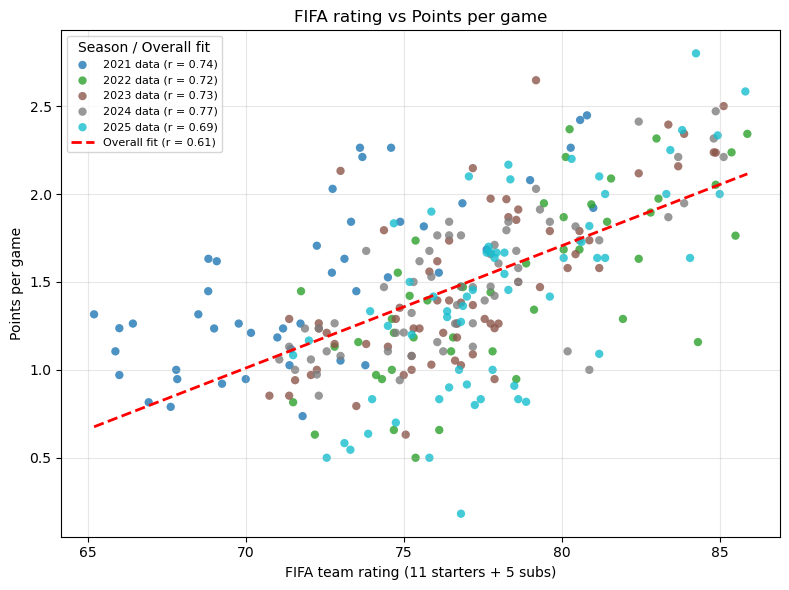

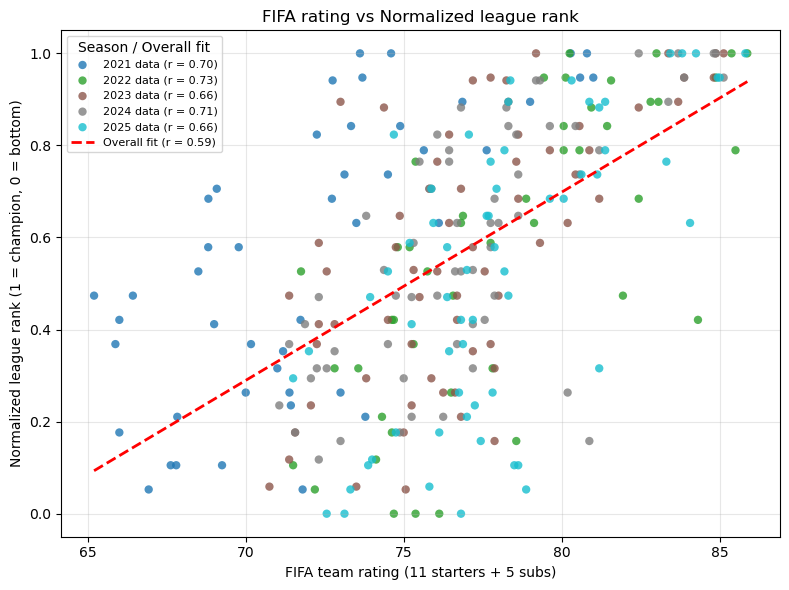

In [23]:
def add_overall_regression(ax, x, y, color="red", linestyle="--", label_prefix="Overall fit"):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        return None

    x_valid = x[mask]
    y_valid = y[mask]

    # Fit y = m x + b
    m, b = np.polyfit(x_valid, y_valid, 1)
    x_line = np.linspace(x_valid.min(), x_valid.max(), 100)
    y_line = m * x_line + b

    # Global Pearson r
    r = np.corrcoef(x_valid, y_valid)[0, 1]

    ax.plot(
        x_line, y_line,
        color=color,
        linestyle=linestyle,
        linewidth=2,
        label=f"{label_prefix} (r = {r:.2f})"
    )
    return r

def season_corr(df, x_col, y_col):
    x = df[x_col].to_numpy(dtype=float)
    y = df[y_col].to_numpy(dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        return np.nan
    return np.corrcoef(x[mask], y[mask])[0, 1]


# =========================================
# Setup: seasons + colors
# =========================================

seasons = sorted(merged_plot["season"].dropna().unique())
cmap = plt.cm.get_cmap("tab10", len(seasons))


# =========================================
# Plot 1: Rating vs Points per Game
# =========================================

fig, ax = plt.subplots(figsize=(8, 6))

for i, season in enumerate(seasons):
    sub = merged_plot[merged_plot["season"] == season]
    r_season = season_corr(sub, "team_rating_weighted", "points_per_game")
    label = f"{season} data (r = {r_season:.2f})" if np.isfinite(r_season) else f"{season} data"
    ax.scatter(
        sub["team_rating_weighted"],
        sub["points_per_game"],
        color=cmap(i),
        alpha=0.8,
        edgecolor="none",
        label=label,
    )

# one global line of best fit across all seasons
add_overall_regression(
    ax,
    merged_plot["team_rating_weighted"],
    merged_plot["points_per_game"],
    color="red",
    linestyle="--",
    label_prefix="Overall fit",
)

ax.set_xlabel("FIFA team rating (11 starters + 5 subs)")
ax.set_ylabel("Points per game")
ax.set_title("FIFA rating vs Points per game")
ax.grid(True, alpha=0.3)
ax.legend(title="Season / Overall fit", fontsize=8)
fig.tight_layout()
plt.show()


# =========================================
# Plot 2: Rating vs Normalized League Rank
# =========================================

fig, ax = plt.subplots(figsize=(8, 6))

for i, season in enumerate(seasons):
    sub = merged_plot[merged_plot["season"] == season]
    r_season = season_corr(sub, "team_rating_weighted", "normalized_rank")
    label = f"{season} data (r = {r_season:.2f})" if np.isfinite(r_season) else f"{season} data"
    ax.scatter(
        sub["team_rating_weighted"],
        sub["normalized_rank"],
        color=cmap(i),
        alpha=0.8,
        edgecolor="none",
        label=label,
    )

# one global line of best fit across all seasons
add_overall_regression(
    ax,
    merged_plot["team_rating_weighted"],
    merged_plot["normalized_rank"],
    color="red",
    linestyle="--",
    label_prefix="Overall fit",
)

ax.set_xlabel("FIFA team rating (11 starters + 5 subs)")
ax.set_ylabel("Normalized league rank (1 = champion, 0 = bottom)")
ax.set_title("FIFA rating vs Normalized league rank")
ax.grid(True, alpha=0.3)
ax.legend(title="Season / Overall fit", fontsize=8)
fig.tight_layout()
plt.show()

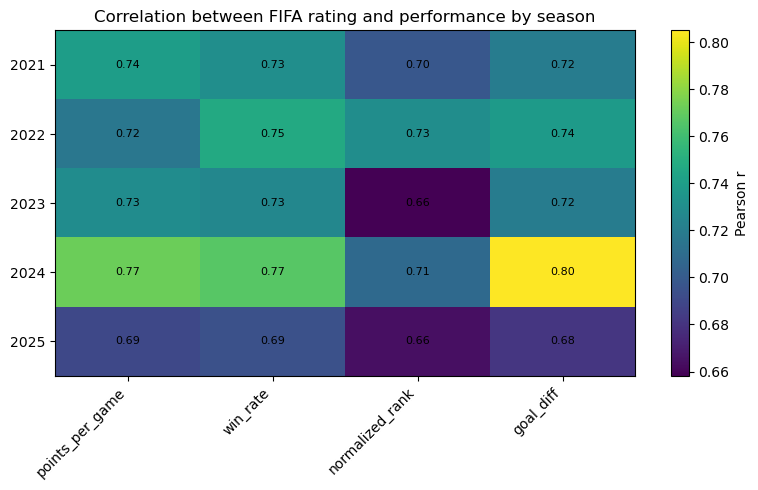

In [24]:
metrics = ["points_per_game", "win_rate", "normalized_rank", "goal_diff"]

rows = []
for season in sorted(merged_plot["season"].dropna().unique()):
    sub = merged_plot[merged_plot["season"] == season]
    row = {"season": season}
    for m in metrics:
        x = sub["team_rating_weighted"].to_numpy(dtype=float)
        y = sub[m].to_numpy(dtype=float)
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 2:
            r = np.nan
        else:
            r = np.corrcoef(x[mask], y[mask])[0, 1]
        row[m] = r
    rows.append(row)

corr_season_metric = pd.DataFrame(rows).set_index("season")

fig, ax = plt.subplots(figsize=(8, 5))

im = ax.imshow(corr_season_metric.values, aspect="auto")

# ticks + labels
ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics, rotation=45, ha="right")

seasons = corr_season_metric.index.tolist()
ax.set_yticks(np.arange(len(seasons)))
ax.set_yticklabels(seasons)

# annotate each cell with r value
for i, season in enumerate(seasons):
    for j, m in enumerate(metrics):
        r = corr_season_metric.iloc[i, j]
        if np.isfinite(r):
            ax.text(j, i, f"{r:.2f}", ha="center", va="center", fontsize=8)

ax.set_title("Correlation between FIFA rating and performance by season")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Pearson r")

plt.tight_layout()
plt.show()

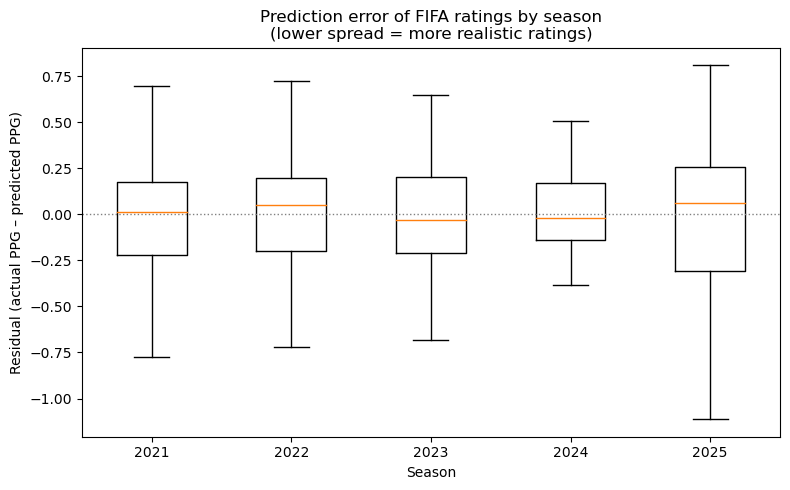

In [19]:
from collections import OrderedDict

residuals_by_season = OrderedDict()

for season in sorted(merged_plot["season"].dropna().unique()):
    sub = merged_plot[merged_plot["season"] == season]
    x = sub["team_rating_weighted"].to_numpy(dtype=float)
    y = sub["points_per_game"].to_numpy(dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    if len(x) < 2:
        continue

    # fit y = m x + b
    m, b = np.polyfit(x, y, 1)
    y_pred = m * x + b
    resid = y - y_pred
    residuals_by_season[season] = resid

# make boxplot of residuals per season
seasons = list(residuals_by_season.keys())
data = [residuals_by_season[s] for s in seasons]

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=seasons, showfliers=False)
plt.axhline(0, color="gray", linestyle=":", linewidth=1)
plt.xlabel("Season")
plt.ylabel("Residual (actual PPG – predicted PPG)")
plt.title("Prediction error of FIFA ratings by season\n(lower spread = more realistic ratings)")
plt.tight_layout()
plt.show()